In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')

import preprocessing as prep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

d:\Matthijs\miniconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
%reload_ext autoreload

In [2]:
# Downloading Data (we run this once)
# 0=Fx, 1=Fy, 2=Fz, 3=Vx, 4=Vy, 5=Vz, 6=AE
manifest = prep.preprocess_phm2010(
    c_files=["c1", "c4", "c6"],
    columns=[5],
    out_dir="../data/raw/phm2010_preprocessed", 
    reset=True
)

Reset output directory: ..\data\raw\phm2010_preprocessed


In [3]:
# Load preprocessed data
manifest = pd.read_csv("../data/raw/phm2010_preprocessed/manifest.csv") # Load 
manifest = prep.add_wear_stage(manifest) # Add labels 

manifest.head()
print(f"Total cuts: {len(manifest)}")
print(f"\nC files: {manifest['c_file'].unique()}")
print(f"Stages: {manifest['stage'].unique()}")

Total cuts: 945

C files: ['c1' 'c4' 'c6']
Stages: ['initial' 'stable' 'rapid']


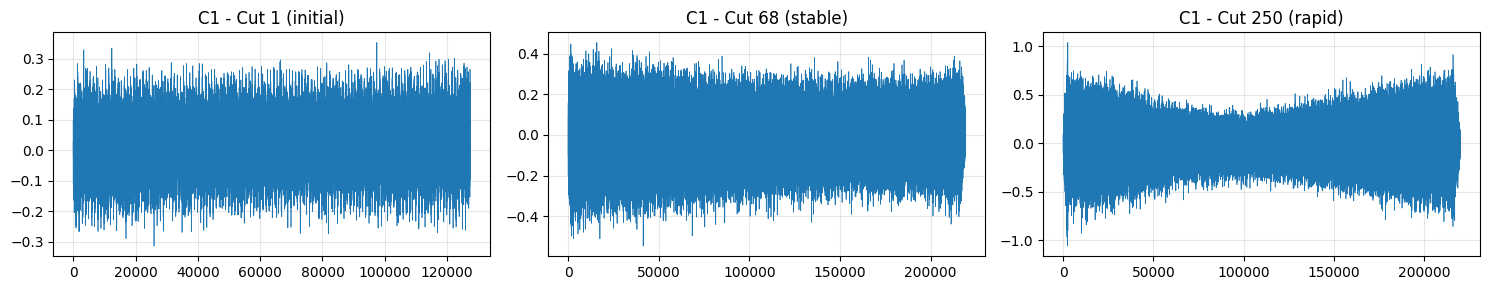

In [4]:
def plot_signals(manifest, cuts, c_files=["c1"], column="Fz_N"):
    """
    Plot signals for specific cut numbers.

    Args:
        manifest: DataFrame with stage column
        cuts: List of cut numbers to plot
        c_files: List of C files to plot
        column: Column name to plot from npz files
                For transfer functions, use "transfer_magnitude"
    """
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(len(c_files), len(cuts), figsize=(15, 3*len(c_files)))
    if len(c_files) == 1:
        axes = axes.reshape(1, -1)

    for i, c_file in enumerate(c_files):
        for j, cut in enumerate(cuts):
            sample = manifest[(manifest["c_file"] == c_file) & (manifest["cut"] == cut)].iloc[0]
            data = np.load(sample["npz_path"])
            
            # Get the signal - works for both original signals and transfer functions
            if column in data:
                signal = data[column]
            else:
                # If column not found, try to get the first available array
                available = list(data.keys())
                if available:
                    signal = data[available[0]]
                    print(f"Warning: '{column}' not found, using '{available[0]}' instead")
                else:
                    print(f"Error: No data in {sample['npz_path']}")
                    continue

            axes[i, j].plot(signal, linewidth=0.5)
            axes[i, j].set_title(f"{c_file.upper()} - Cut {cut} ({sample['stage']})")
            axes[i, j].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
plot_signals(manifest, cuts=[1, 68, 250], c_files=["c1"], column="Fz_N")

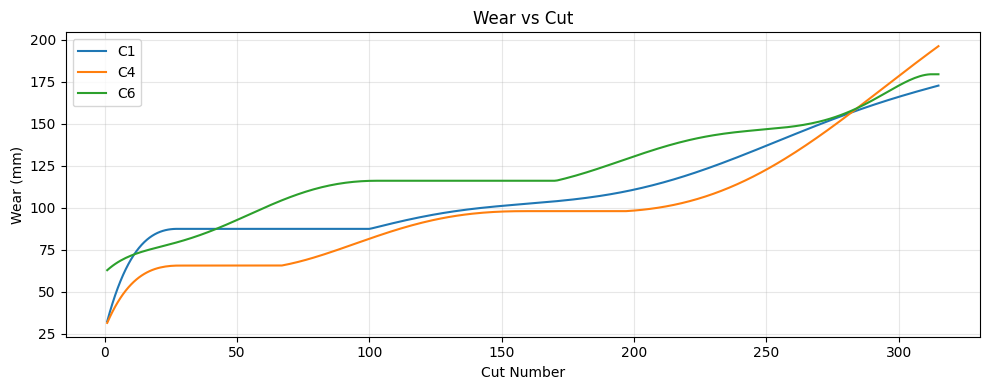

In [5]:
prep.plot_wear(manifest, c_files=["c1", "c4", "c6"])

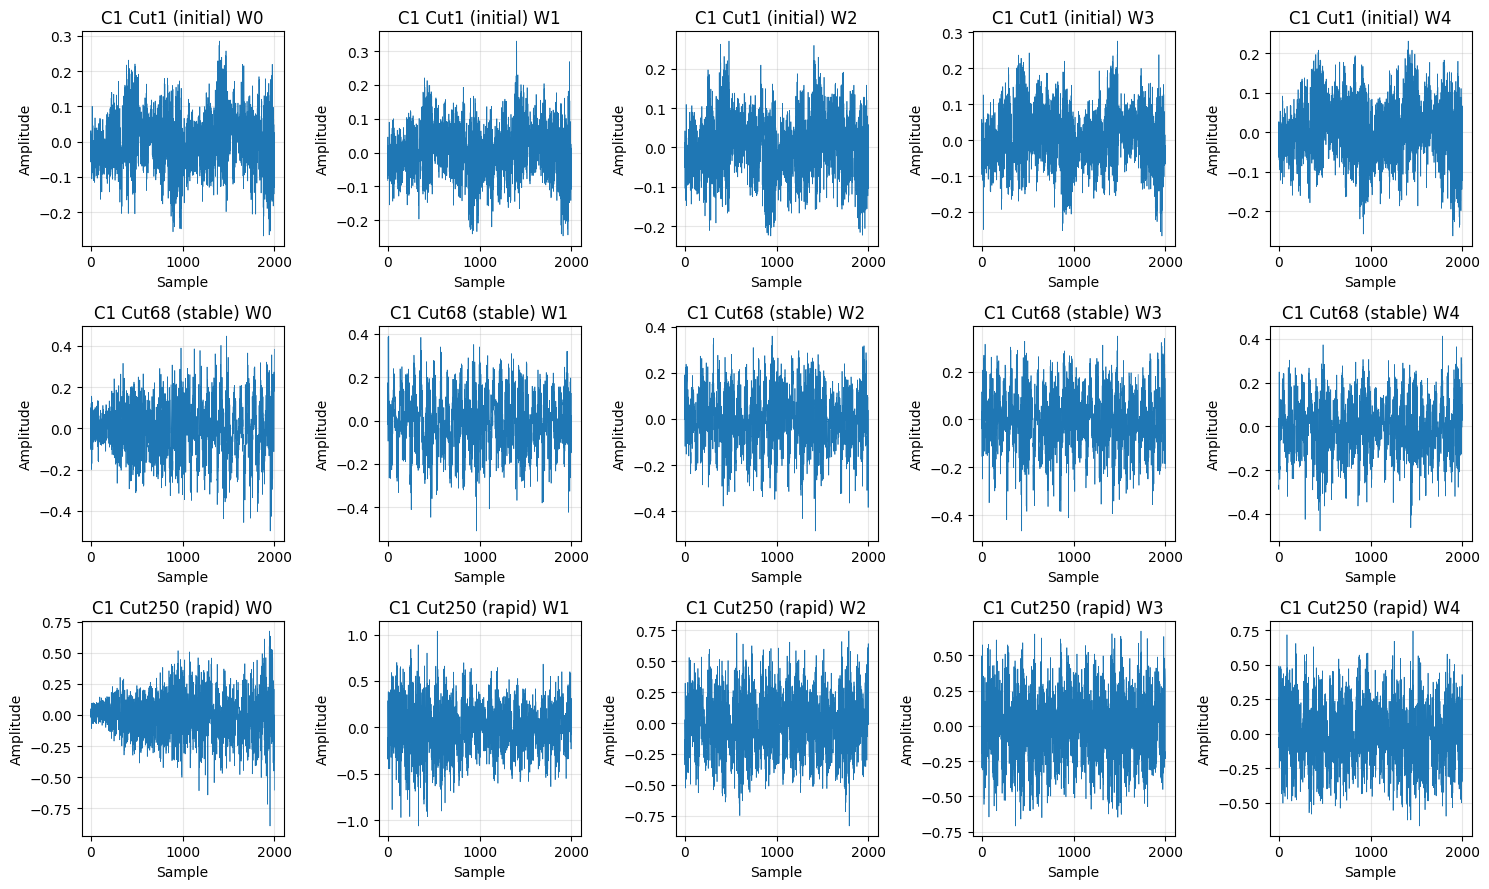


Total windows: 30
Columns: ['Vz_g']
C files: ['c1']
Cuts: [1, 68, 250]
Stages: ['initial', 'rapid', 'stable']


In [ ]:
prep.plot_transforms(
        manifest,
        window_length=2000,
        slice_start=0,
        slice_end=20000,
        transform=None,  # No transform = raw signal
        c_files=["c1"],
        cut_numbers=[1, 68, 250],
        max_windows=5
    )

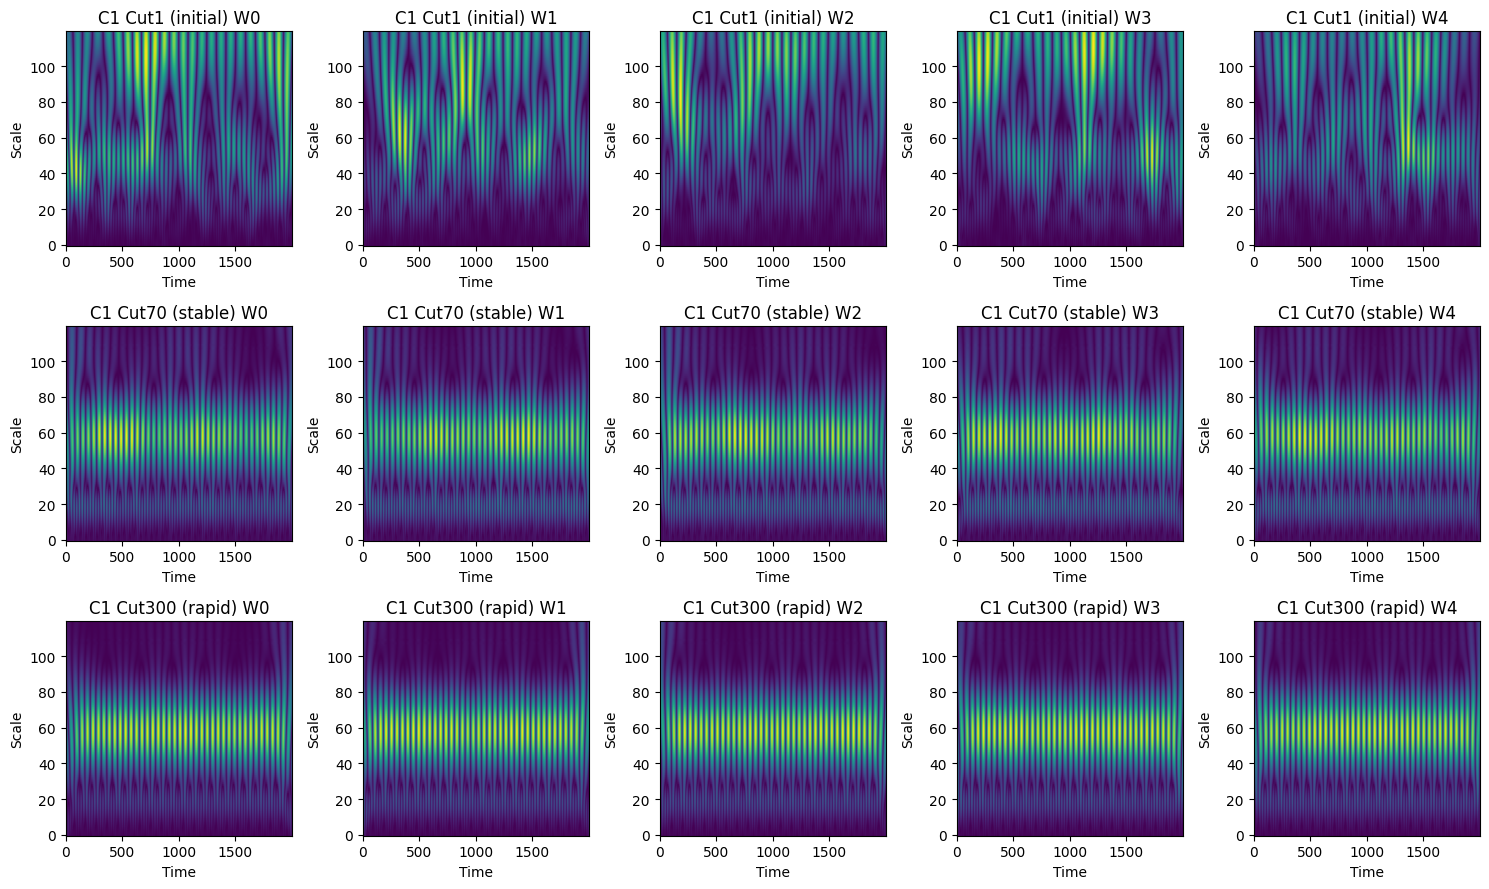


Total windows: 42
Transform shape: (120, 2000)
Columns: ['Fz_N']
C files: ['c1']
Cuts: [1, 70, 300]
Stages: ['initial', 'rapid', 'stable']


In [44]:
CWT_PARAMS = {
        'scales': np.arange(20, 140, 1),
        'wavelet': 'morl'}

WINDOW_LENGTH = 15000
OVERLAP = 0
SLICE_START = 2000
SLICE_END = 200000

prep.plot_transforms(
        manifest,
        window_length=2000,
        slice_start=2000,
        slice_end=30000,
        transform='cwt',
        transform_params=CWT_PARAMS,
        c_files=["c1"],
        cut_numbers=[1, 70, 300],
        max_windows=5
    )

# STFT

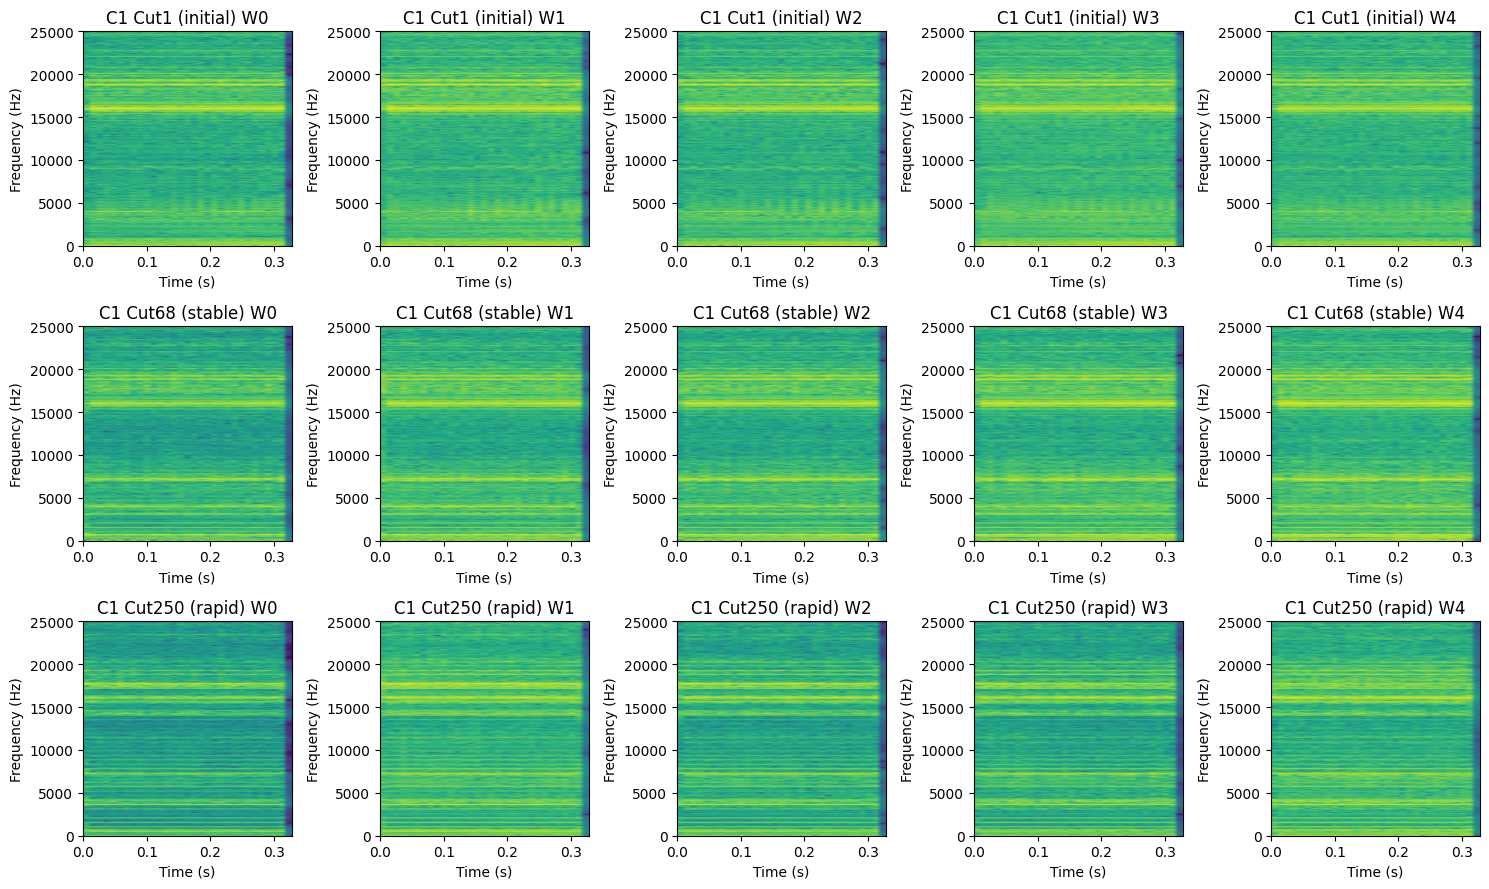


Total windows: 34
Transform shape: (515, 31)
Columns: ['Vz_g']
C files: ['c1']
Cuts: [1, 68, 250]
Stages: ['initial', 'rapid', 'stable']


Exporting images: 100%|██████████| 12273/12273 [1:06:30<00:00,  3.08it/s]



✓ Saved 12273 images to ../data/processed/dataset_Vz_stft_log_25000
  Stages: ['initial', 'rapid', 'stable']


In [9]:

MAX_FREQ = 25000
WINDOW_LENGTH = 15000
OVERLAP = 0
SLICE_START = 2000
SLICE_END = 200000

    # STFT parameters with log scale
STFT_PARAMS_LOG = {
        'fs': 50000,
        'nperseg': 514 * 2,
        'noverlap': 257 * 2,
        'log_scale': True  # Log magnitude in dB
    }


prep.plot_transforms(
        manifest,
        window_length=WINDOW_LENGTH,
        overlap=OVERLAP,
        slice_start=SLICE_START,
        slice_end=SLICE_END,
        transform='stft',
        transform_params=STFT_PARAMS_LOG,
        c_files=["c1"],
        cut_numbers=[1, 68, 250],
        max_windows=5,
)

prep.export_dataset(
    manifest,
    output_folder="../data/processed/dataset_Vz_stft_log_25000",
    window_length=WINDOW_LENGTH,
    overlap=OVERLAP,
    slice_start=SLICE_START,
    slice_end=SLICE_END,
    transform='stft',
    transform_params=STFT_PARAMS_LOG,
    c_files=None,
    max_freq=MAX_FREQ,
    dpi=200
)

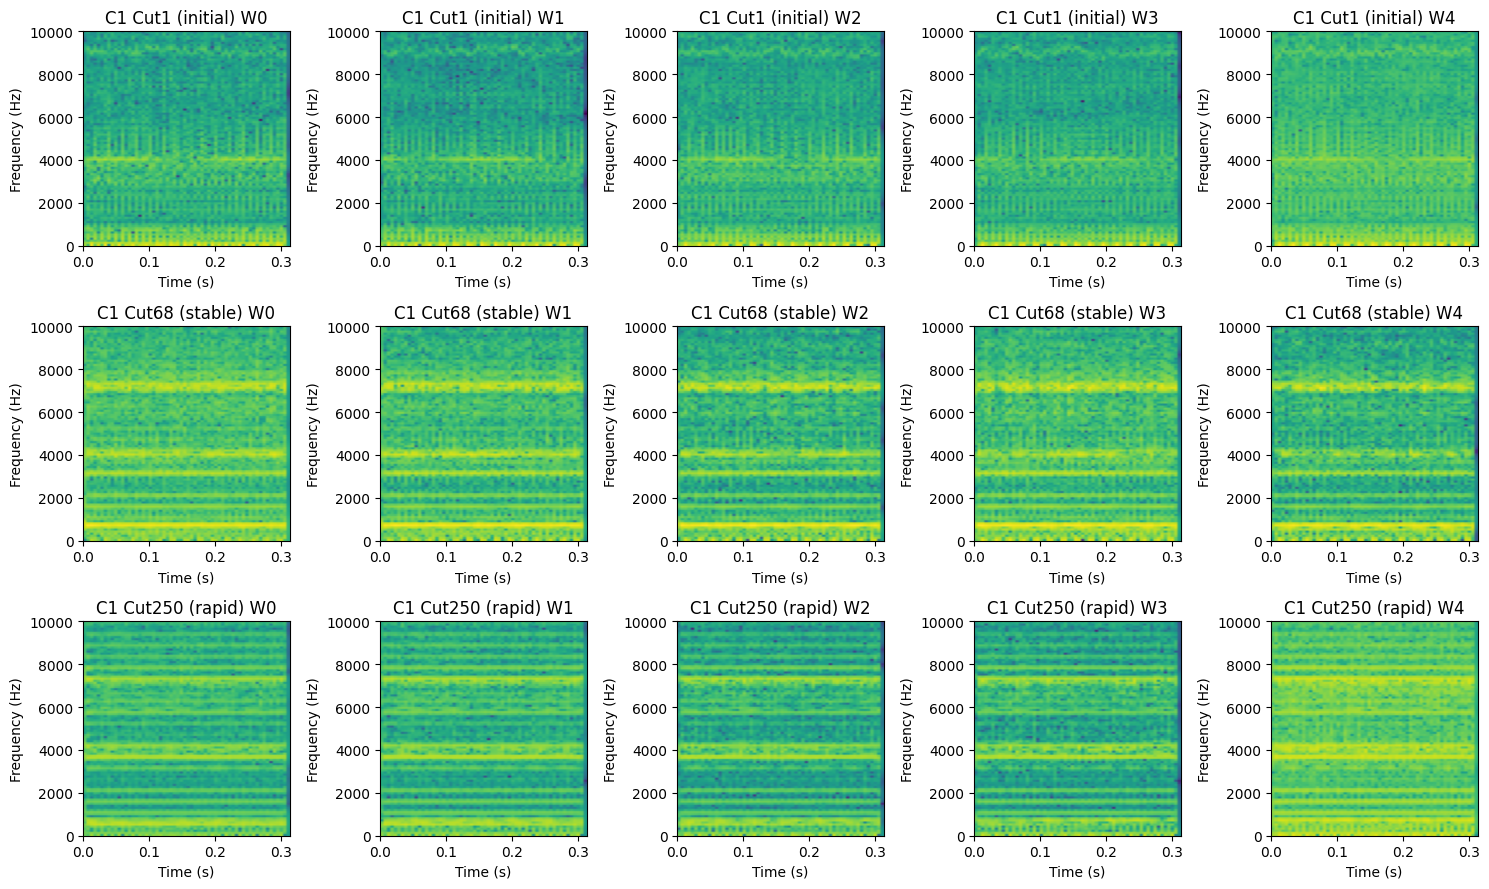


Total windows: 34
Transform shape: (258, 60)
Columns: ['Vz_g']
C files: ['c1']
Cuts: [1, 68, 250]
Stages: ['initial', 'rapid', 'stable']


Exporting images: 100%|██████████| 12273/12273 [30:37<00:00,  6.68it/s] 



✓ Saved 12273 images to ../data/processed/dataset_Vz_stft_log_10000
  Stages: ['initial', 'rapid', 'stable']


In [10]:
MAX_FREQ = 10000
WINDOW_LENGTH = 15000
OVERLAP = 0
SLICE_START = 2000
SLICE_END = 200000

    # STFT parameters with log scale
STFT_PARAMS_LOG = {
        'fs': 50000,
        'nperseg': 514 ,
        'noverlap': 257 ,
        'log_scale': True  # Log magnitude in dB
    }


prep.plot_transforms(
        manifest,
        window_length=WINDOW_LENGTH,
        overlap=OVERLAP,
        slice_start=SLICE_START,
        slice_end=SLICE_END,
        transform='stft',
        transform_params=STFT_PARAMS_LOG,
        c_files=["c1"],
        cut_numbers=[1, 68, 250],
        max_windows=5,
        max_freq=MAX_FREQ
)

prep.export_dataset(
    manifest,
    output_folder="../data/processed/dataset_Vz_stft_log_10000",
    window_length=WINDOW_LENGTH,
    overlap=OVERLAP,
    slice_start=SLICE_START,
    slice_end=SLICE_END,
    transform='stft',
    transform_params=STFT_PARAMS_LOG,
    c_files=None,
    max_freq=MAX_FREQ,
    dpi=200
)

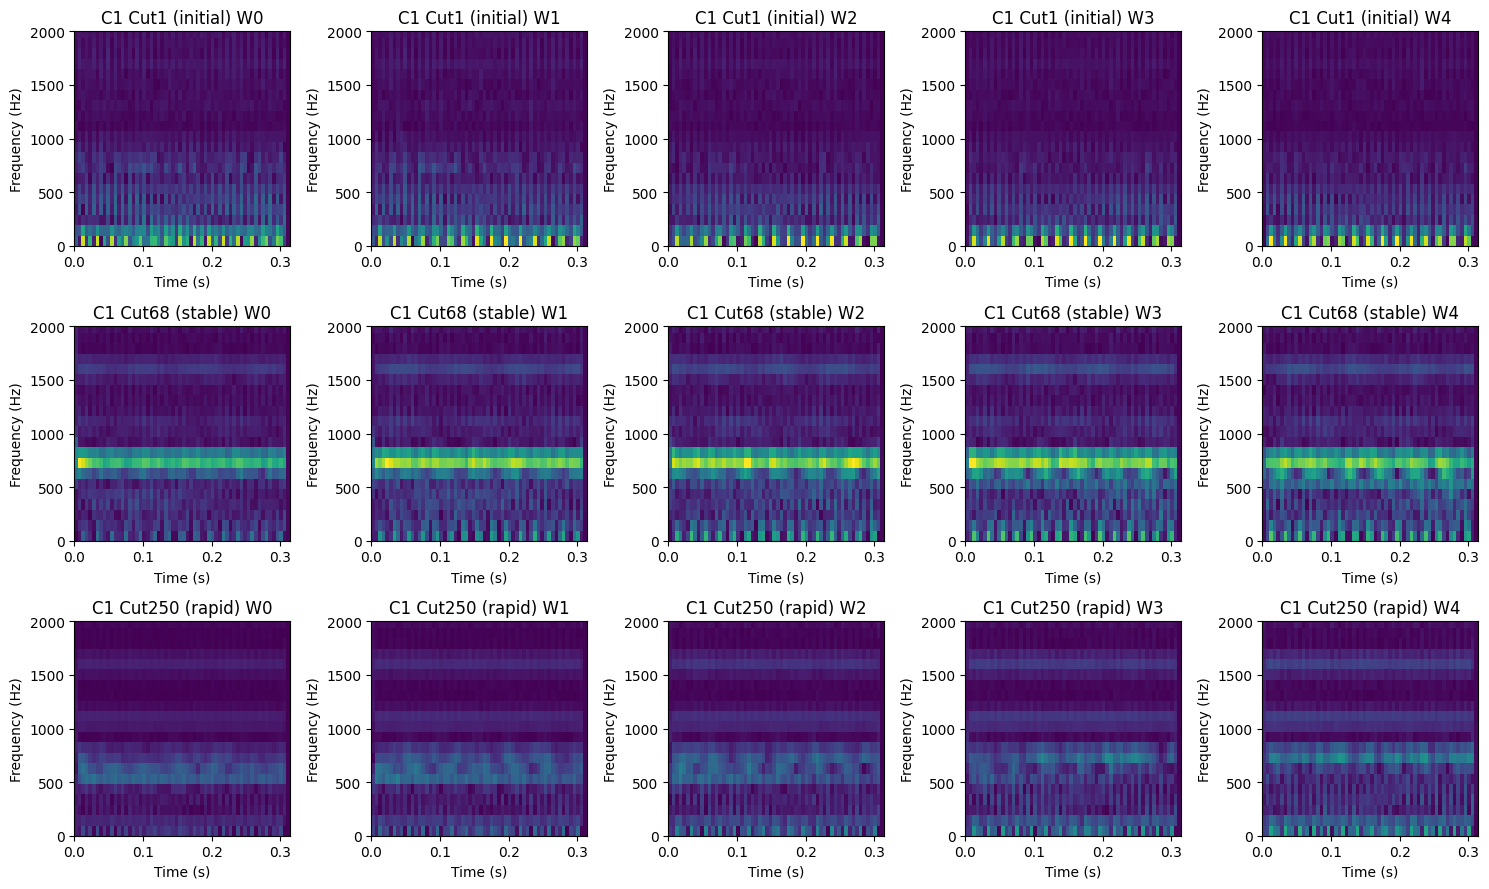


Total windows: 34
Transform shape: (258, 60)
Columns: ['Vz_g']
C files: ['c1']
Cuts: [1, 68, 250]
Stages: ['initial', 'rapid', 'stable']


Exporting images: 100%|██████████| 12273/12273 [31:08<00:00,  6.57it/s] 



✓ Saved 12273 images to ../data/processed/dataset_Vz_stft_2000
  Stages: ['initial', 'rapid', 'stable']


In [11]:

MAX_FREQ = 2000
WINDOW_LENGTH = 15000
OVERLAP = 0
SLICE_START = 2000
SLICE_END = 200000

    # STFT parameters with log scale
STFT_PARAMS = {
        'fs': 50000,
        'nperseg': 514 ,
        'noverlap': 257 ,
        'log_scale': False  
    }


prep.plot_transforms(
        manifest,
        window_length=WINDOW_LENGTH,
        overlap=OVERLAP,
        slice_start=SLICE_START,
        slice_end=SLICE_END,
        transform='stft',
        transform_params=STFT_PARAMS, 
        c_files=["c1"],
        cut_numbers=[1, 68, 250],
        max_windows=5,
        max_freq=MAX_FREQ
    )

prep.export_dataset(
    manifest,
    output_folder="../data/processed/dataset_Vz_stft_2000",
    window_length=WINDOW_LENGTH,
    overlap=OVERLAP,
    slice_start=SLICE_START,
    slice_end=SLICE_END,
    transform='stft',
    transform_params=STFT_PARAMS,
    c_files=None,
    max_freq=MAX_FREQ,
    dpi=200
)



# TF STFT

In [ ]:
# prep.export_dataset(
#     manifest,
#     output_folder="../data/processed/dataset_stft_log_nperseg1028",
#     window_length=15000,
#     overlap=0,
#     slice_start=2000,
#     slice_end=200000,
#     transform='stft',
#     transform_params=STFT_1028,
#     c_files=["c1", "c4", "c6"],
#     max_freq=20000,
#     dpi=200
# )

In [2]:
##Downloading Data (we run this once)
manifest = prep.preprocess_phm2010(
    c_files=["c1"],
    columns=[2,5],
    out_dir="../data/raw/phm2010_preprocessed", 
    reset=True
)



Reset output directory: ..\data\raw\phm2010_preprocessed


In [2]:
manifest_tf = pd.read_csv("../data/raw/phm2010_preprocessed/manifest.csv") # Load 


In [3]:
manifest_tf = prep.add_wear_stage(manifest_tf) # Add labels 


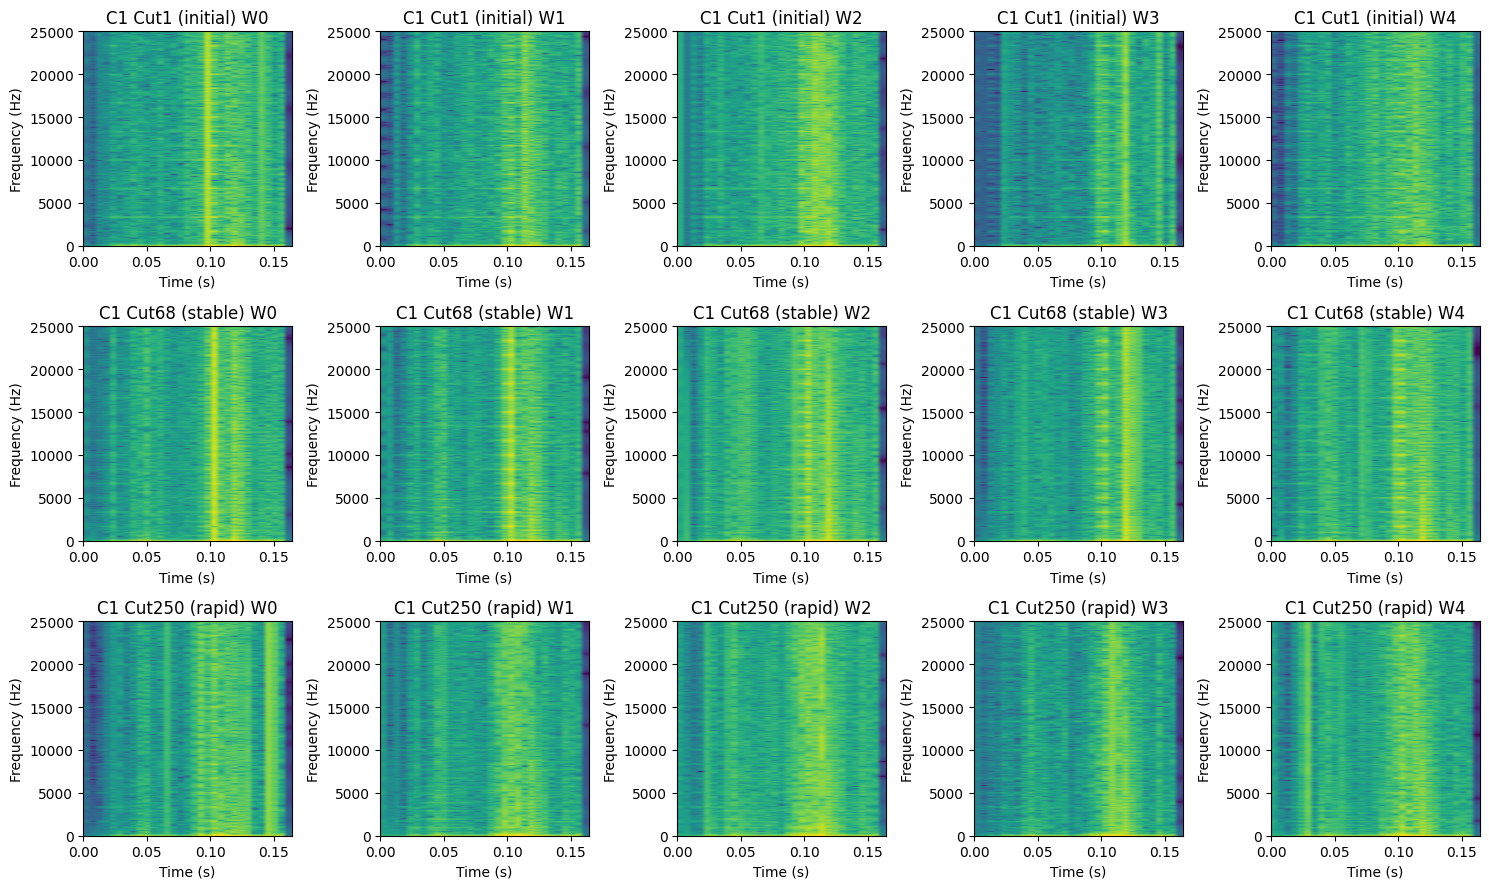


Total windows: 34
Transform shape: (258, 31)
Columns: ['Fz_N_to_Vz_g']
C files: ['c1']
Cuts: [1, 68, 250]
Stages: ['initial', 'rapid', 'stable']


In [6]:
MAX_FREQ = 25000
WINDOW_LENGTH = 15000
OVERLAP = 0
SLICE_START = 2000
SLICE_END = 200000

STFT_PARAMS = {
        'fs': 50000,
        'nperseg': 514 ,
        'noverlap': 257 ,
        'log_scale': True
    }

prep.plot_transforms_2(
    manifest_tf,
    window_length=WINDOW_LENGTH,
    overlap=OVERLAP,
    slice_start=SLICE_START,
    slice_end=SLICE_END,
    transform='stft',
    transform_params=STFT_PARAMS,
    c_files=["c1"],
    cut_numbers=[1, 68, 250],
    max_windows=5,
    process_fn=prep.process_windows_2,  # Use TF processing
    tf_input_col='Fz_N',
    tf_output_col='Vz_g', 
    max_freq=MAX_FREQ
)

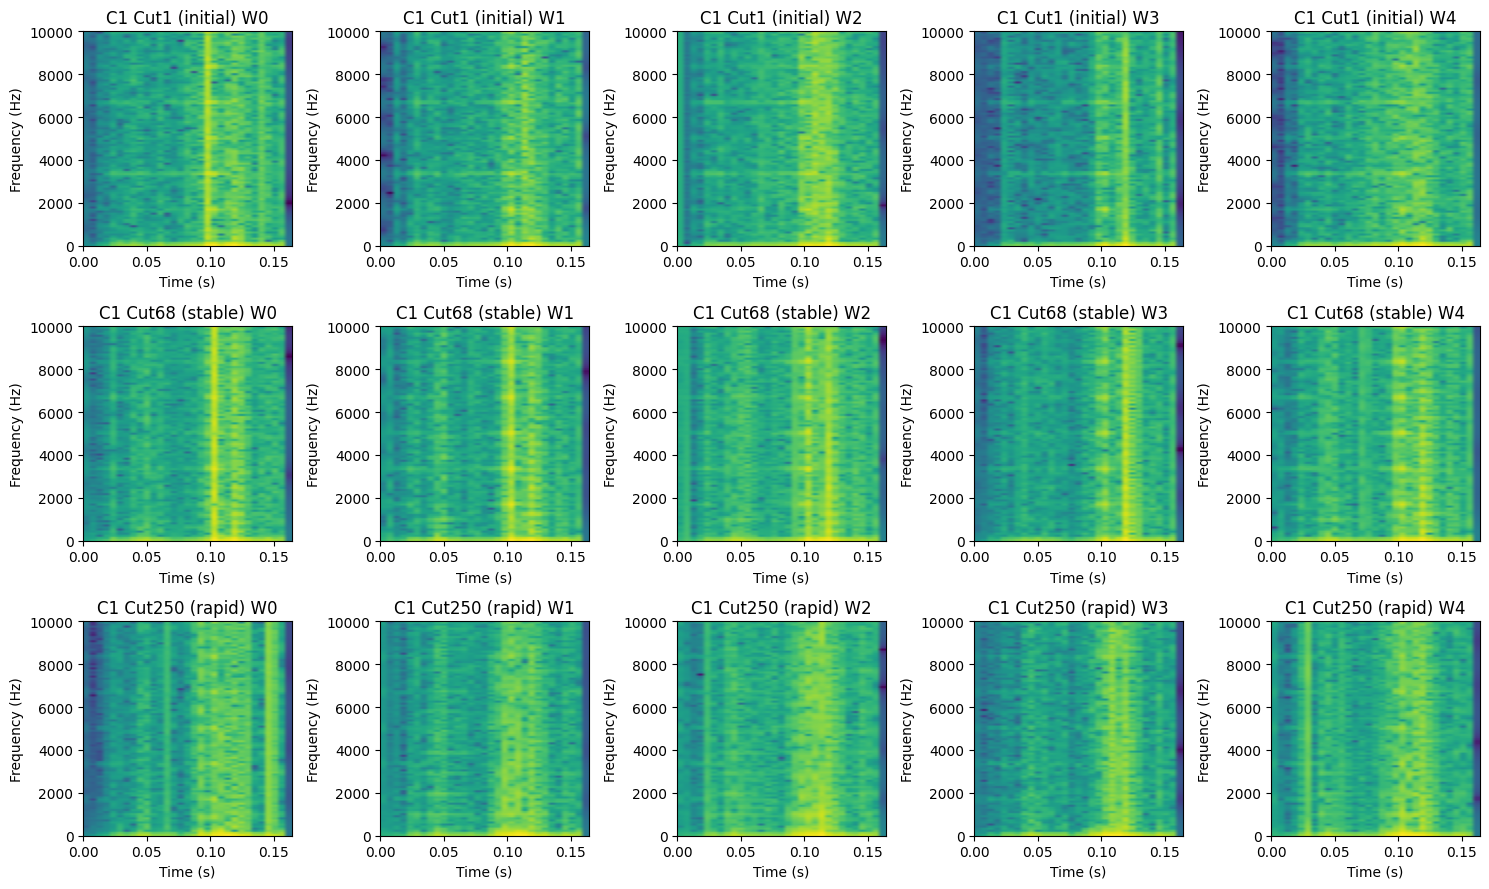


Total windows: 34
Transform shape: (258, 31)
Columns: ['Fz_N_to_Vz_g']
C files: ['c1']
Cuts: [1, 68, 250]
Stages: ['initial', 'rapid', 'stable']


In [9]:

MAX_FREQ = 10000
WINDOW_LENGTH = 15000
OVERLAP = 0
SLICE_START = 2000
SLICE_END = 200000

STFT_PARAMS = {
        'fs': 50000,
        'nperseg': 514 ,
        'noverlap': 257 ,
        'log_scale': True
    }

prep.plot_transforms_2(
    manifest_tf,
    window_length=WINDOW_LENGTH,
    overlap=OVERLAP,
    slice_start=SLICE_START,
    slice_end=SLICE_END,
    transform='stft',
    transform_params=STFT_PARAMS,
    c_files=["c1"],
    cut_numbers=[1, 68, 250],
    max_windows=5,
    process_fn=prep.process_windows_2,  # Use TF processing
    tf_input_col='Fz_N',
    tf_output_col='Vz_g', 
    max_freq=MAX_FREQ
)




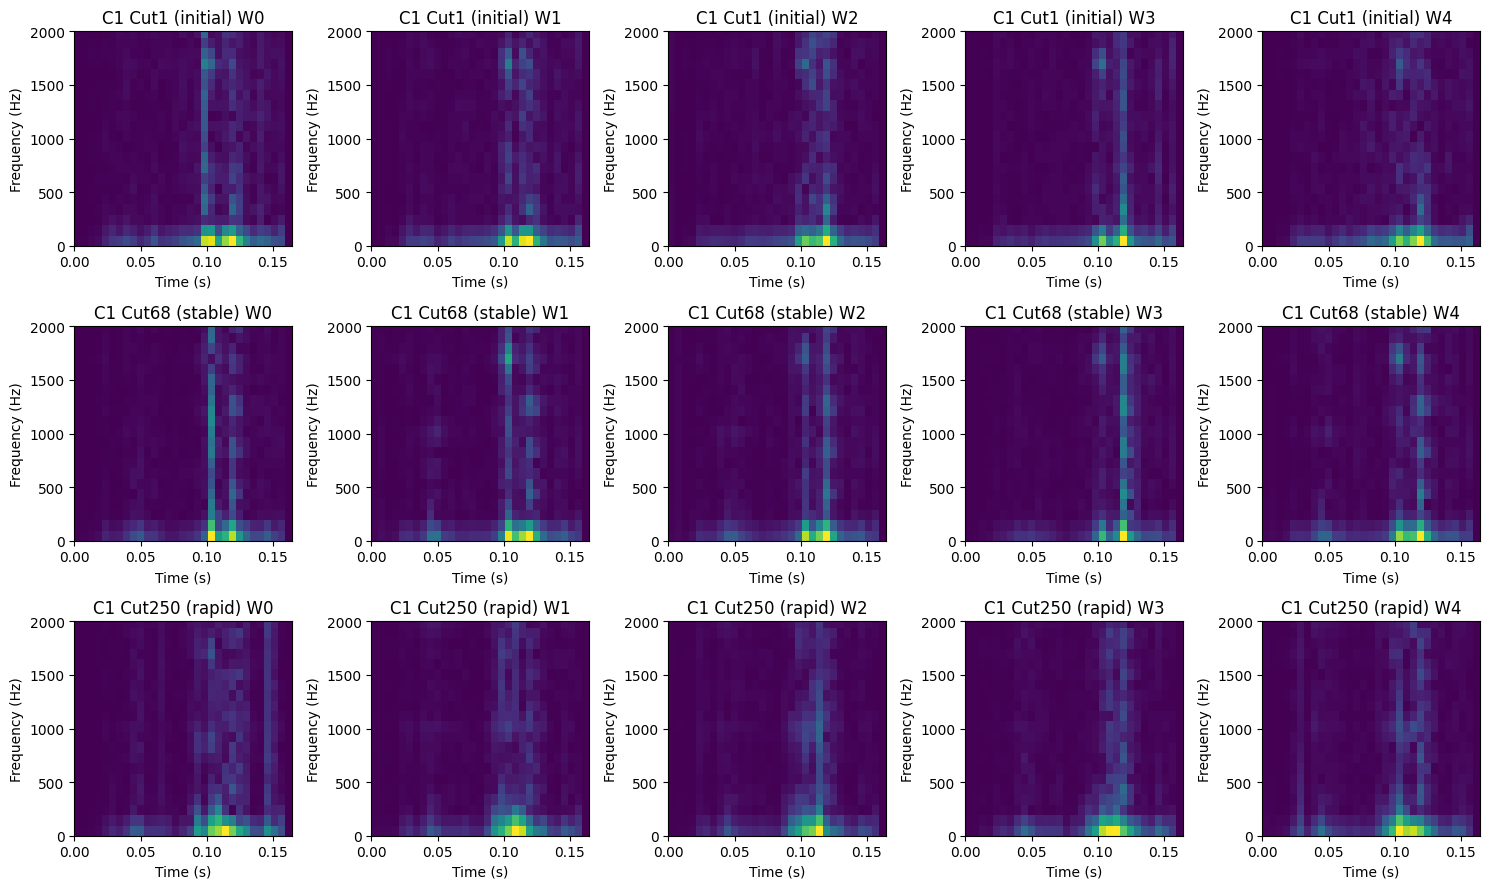


Total windows: 34
Transform shape: (258, 31)
Columns: ['Fz_N_to_Vz_g']
C files: ['c1']
Cuts: [1, 68, 250]
Stages: ['initial', 'rapid', 'stable']


In [10]:

MAX_FREQ = 2000
WINDOW_LENGTH = 15000
OVERLAP = 0
SLICE_START = 2000
SLICE_END = 200000

STFT_PARAMS = {
        'fs': 50000,
        'nperseg': 514 ,
        'noverlap': 257 ,
        'log_scale': False
    }

prep.plot_transforms_2(
    manifest_tf,
    window_length=WINDOW_LENGTH,
    overlap=OVERLAP,
    slice_start=SLICE_START,
    slice_end=SLICE_END,
    transform='stft',
    transform_params=STFT_PARAMS,
    c_files=["c1"],
    cut_numbers=[1, 68, 250],
    max_windows=5,
    process_fn=prep.process_windows_2,  # Use TF processing
    tf_input_col='Fz_N',
    tf_output_col='Vz_g', 
    max_freq=MAX_FREQ
)
